In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = '/content/drive/MyDrive/Autonomous Driving/bev_classifier/data/bev_mini_processed'
image_dataset = datasets.ImageFolder(data_dir, data_transforms)

# 80/20 train/val split
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

dataloaders = {"train": torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=True, num_workers=4),
               "val": torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)
              }
dataset_sizes = {"train": train_size, "val": val_size}
class_names = image_dataset.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['fourway', 'straight', 'threeway_left', 'threeway_right', 'threeway_t']


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


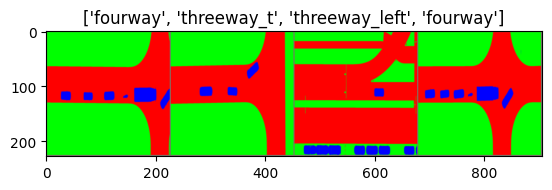

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(preds[j])
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
model_ft = models.mobilenet_v2(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 212MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 2.0237 Acc: 0.6000
val Loss: 0.3818 Acc: 0.9000

Epoch 1/9
----------
train Loss: 0.4473 Acc: 0.8611
val Loss: 0.4276 Acc: 0.8444

Epoch 2/9
----------
train Loss: 0.3143 Acc: 0.9028
val Loss: 0.2135 Acc: 0.9444

Epoch 3/9
----------
train Loss: 0.2115 Acc: 0.9250
val Loss: 0.1349 Acc: 0.9667

Epoch 4/9
----------
train Loss: 0.1854 Acc: 0.9500
val Loss: 0.1239 Acc: 0.9667

Epoch 5/9
----------
train Loss: 0.2551 Acc: 0.9361
val Loss: 0.1390 Acc: 0.9667

Epoch 6/9
----------
train Loss: 0.2641 Acc: 0.9167
val Loss: 0.1359 Acc: 0.9667

Epoch 7/9
----------
train Loss: 0.1851 Acc: 0.9389
val Loss: 0.1165 Acc: 0.9667

Epoch 8/9
----------
train Loss: 0.2030 Acc: 0.9389
val Loss: 0.1462 Acc: 0.9667

Epoch 9/9
----------
train Loss: 0.1902 Acc: 0.9417
val Loss: 0.1247 Acc: 0.9667

Training complete in 2m 47s
Best val Acc: 0.966667


tensor(4, device='cuda:0')


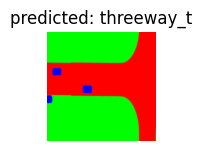

tensor(4, device='cuda:0')


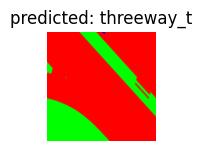

tensor(1, device='cuda:0')


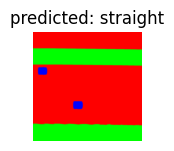

tensor(4, device='cuda:0')


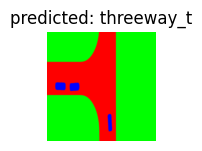

tensor(1, device='cuda:0')


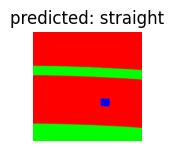

tensor(4, device='cuda:0')


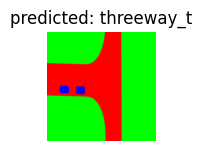

In [ ]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft, "/content/drive/MyDrive/Autonomous Driving/bev_classifier/weights.pth")

In [ ]:
model_pt = torch.load("/content/drive/MyDrive/Autonomous Driving/bev_classifier/weights.pth")

tensor(2, device='cuda:0')


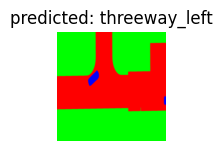

tensor(3, device='cuda:0')


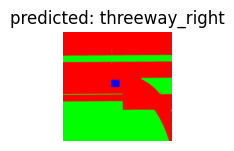

tensor(4, device='cuda:0')


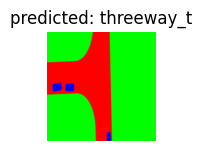

tensor(1, device='cuda:0')


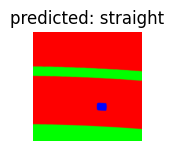

tensor(0, device='cuda:0')


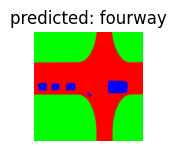

tensor(0, device='cuda:0')


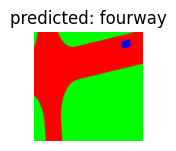

In [ ]:
visualize_model(model_pt)